In [1]:
%%capture
!pip install xbatcher tensorboard

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/home/jovyan/ForestLST/util/__init__.py:22: UserWarning: Earth Engine API not found! Module util.gee will not be loaded.
  warnings.warn("Earth Engine API not found! Module util.gee will not be loaded.")


Prepare data

In [3]:
reload(util.training)

<module 'util.training_torch' from '/home/jovyan/ForestLST/util/training_torch.py'>

In [4]:
from google.cloud.storage import Client
client = Client(project="forest-lst")
df = util.gcs.read_gcs_csv(client, "preisler_tfdata", "preisler-rectangular")

In [5]:
ds = df.drop(["system:index", ".geo"], axis=1).set_index(["year", "latitude", "longitude"]).to_xarray()

In [6]:
ds

<xarray.Dataset>
Dimensions:        (year: 24, latitude: 340, longitude: 261)
Coordinates:
  * year           (year) int64 2000 2001 2002 2003 2004 ... 2020 2021 2022 2023
  * latitude       (latitude) float64 32.57 32.6 32.63 ... 41.95 41.98 42.01
  * longitude      (longitude) float64 -124.4 -124.4 -124.3 ... -115.1 -115.1
Data variables:
    fire           (year, latitude, longitude) float64 nan nan nan ... nan nan
    near           (year, latitude, longitude) float64 nan nan nan ... nan nan
    pct_mortality  (year, latitude, longitude) float64 nan nan nan ... nan nan
    ppt_sum        (year, latitude, longitude) float64 nan nan nan ... nan nan
    prcp           (year, latitude, longitude) float64 nan nan nan ... nan nan
    rhost          (year, latitude, longitude) float64 nan nan nan ... nan nan
    sum_vp         (year, latitude, longitude) float64 nan nan nan ... nan nan
    win_tmin       (year, latitude, longitude) float64 nan nan nan ... nan nan

Make sure windowing works right

In [7]:
window = dict(latitude=[4, False], longitude=[4, False], year=[5, False])
mort_ds = util.training.WindowXarrayDataset(ds, window, mask_var="pct_mortality")

In [8]:
len(mort_ds)

121750

In [9]:
mort_window = mort_ds[10]
window_x = mort_window.isel(year=slice(None, -1))
window_y = mort_window.isel(year=-1)

In [10]:
window_x = window_x[["fire", "pct_mortality", "ppt_sum"]]\
    .to_stacked_array(new_dim="band", sample_dims=["year", "latitude", "longitude"])\
    .transpose("year", "band", ...)\
    .values

In [11]:
window_y

<xarray.Dataset>
Dimensions:        (latitude: 4, longitude: 4)
Coordinates:
    year           int64 2004
  * latitude       (latitude) float64 32.72 32.75 32.78 32.81
  * longitude      (longitude) float64 -116.7 -116.6 -116.6 -116.5
Data variables:
    fire           (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    near           (latitude, longitude) float64 0.0 0.0388 ... 0.1416 0.1416
    pct_mortality  (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.042
    ppt_sum        (latitude, longitude) float64 468.9 484.5 ... 590.7 595.4
    prcp           (latitude, longitude) float64 261.8 294.1 ... 324.5 330.9
    rhost          (latitude, longitude) float64 0.0 0.0 0.0 ... 0.0173 0.02489
    sum_vp         (latitude, longitude) float64 539.7 508.5 ... 507.7 493.5
    win_tmin       (latitude, longitude) float64 -1.534 -2.158 ... -3.422 -4.045

Set up model definition

In [12]:
class DamageConvLSTM(torch.nn.Module):
    '''
    Conv LSTM taking tensors of shape (N, T, C, H, W) and outputting (N, C, H, W)
    '''
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(DamageConvLSTM, self).__init__()
        self.convlstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers,
                                batch_first=batch_first, bias=bias, return_all_layers=return_all_layers)

        self.conv    = torch.nn.Conv2d(hidden_dim, 1, kernel_size=1)
        self.sigmoid = torch.nn.Sigmoid()
        self.bn      = torch.nn.BatchNorm3d(input_dim)

    def forward(self, X):
        # Torch expects the channel axis to be second, but convlstm expects it
        # to be third. So we have to permute the input, batchnorm it, and then
        # permute it back.
        # (N, T, C, H, W) -> (N, C, T, H, W)
        X = X.permute(0, 2, 1, 3, 4)
        X = self.bn(X)
        # (N, C, T, H, W) -> (N, T, C, H, W)
        X = X.permute(0, 2, 1, 3, 4)
        
        # Pass to convlstm
        X = self.convlstm(X)[1][0][0]
        # Convolve out the hidden dimensions
        X = self.conv(X)
        # Pass to sigmoid
        X = self.sigmoid(X)
        # Drop channel axis
        return X.squeeze(1)
        

In [13]:
from util.convlstm import ConvLSTM

input_vars = ["pct_mortality", "fire", "ppt_sum"]
input_channel = len(input_vars)
hidden_dim = 16
num_layers = 3
kernel = (3, 3)

m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True) 

Verify that the shapes all work out.

In [14]:
input_tensor = torch.tensor(window_x).unsqueeze(0).to(torch.float32)
m(input_tensor).size() # should be (1, 4, 4)

torch.Size([1, 4, 4])

Data pipeline

In [15]:
# Prepare data laoders. Since we are using a 5-year lookback here, each dataset
# has to be temporally disjoint so we don't leak data. Since 2020 had very few
# surveys we have to ignore it.
years = ds.year.values
train_years = np.concatenate((years[:5], years[10:15]))
valid_years = years[5:10]
test_years  = years[15:20]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2000 2001 2002 2003 2004 2010 2011 2012 2013 2014]
Validation years: [2005 2006 2007 2008 2009]
Testing years: [2015 2016 2017 2018 2019]


In [16]:
# N.b. we could boost the number of samples by allowing up to 20% NA in each window and then
# replacing these values with zero in the dataloader.
train_wds = util.training.WindowXarrayDataset(ds.sel(year=train_years), window, mask_var="pct_mortality")
valid_wds = util.training.WindowXarrayDataset(ds.sel(year=valid_years), window, mask_var="pct_mortality")
test_wds  = util.training.WindowXarrayDataset(ds.sel(year= test_years), window, mask_var="pct_mortality")

print("Count of examples")
print("Training:", len(train_wds))
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Training: 35820
Validation: 7304
Testing: 6588


In [17]:
from torch.utils.data import DataLoader

bands = ["pct_mortality", "fire", "ppt_sum"]
target = "pct_mortality"
dtype = torch.float32

def collator(patch_list):
    X = torch.stack([
        torch.tensor(
            np.stack(
                [patch[b].isel(year=slice(None, -1)).values for b in bands],
                axis=1
            ),
            dtype=dtype
        )
        for patch in patch_list
    ])

    y = torch.stack([
        torch.tensor(patch[target].isel(year=-1).values, dtype=dtype)
        for patch in patch_list
    ])

    return X, y

batch_size = 16

# Setting the RNG to host device is necessary if we want to run on GPU
train_loader = DataLoader(train_wds, batch_size, shuffle=True, collate_fn=collator, generator=torch.Generator(device=device))
valid_loader = DataLoader(valid_wds, batch_size, shuffle=True, collate_fn=collator, generator=torch.Generator(device=device))
test_loader  = DataLoader(test_wds , batch_size, shuffle=True, collate_fn=collator, generator=torch.Generator(device=device))

In [18]:
# Again make sure the sizes work out
X, y = tuple(next(iter(train_loader)))
print(X.shape)
out = m(X)
print(out.shape)
assert out.shape == y.shape

torch.Size([16, 4, 3, 4, 4])
torch.Size([16, 4, 4])


Training loop

In [19]:
reload(util.training)

<module 'util.training_torch' from '/home/jovyan/ForestLST/util/training_torch.py'>

In [20]:
import torchmetrics

model_name = "convlstm__4_4_5__mort_fire_ppt__temporal"
os.makedirs(f"logs/{model_name}", exist_ok=True)

def image_mse_loss(output, target):
    err = (output - target) ** 2
    return err.sum(0)

loss = torch.nn.MSELoss()
m = DamageConvLSTM(input_channel, 8, kernel, num_layers, batch_first=True)
opt  = torch.optim.Adam(m.parameters(), lr=0.005)
metrics = [
    torchmetrics.regression.ExplainedVariance(),
    torchmetrics.regression.MeanSquaredError()
    #torchmetrics.regression.R2Score()
]
trainer = util.training.BaseTrainer(
    m, opt, loss, train_loader, valid_loader,
    metrics=metrics, 
    n_epochs=20,
    tensorboard_log=os.path.join("logs", model_name, "history"),
    model_log=os.path.join("logs", model_name, "model.pth"),
    #timing_log=os.path.join("logs", model_name, "timing.json")
)

In [21]:
trainer.train()

Epoch 1/20
                                                Train  \
ExplainedVariance()  tensor(-0.0836, device='cuda:0')   
Loss                                         0.012143   
MeanSquaredError()    tensor(0.0121, device='cuda:0')   

                                               Valid  
ExplainedVariance()  tensor(0.0001, device='cuda:0')  
Loss                 tensor(0.0040, device='cuda:0')  
MeanSquaredError()   tensor(0.0040, device='cuda:0')  

Epoch 2/20
                                                Train  \
ExplainedVariance()  tensor(-0.0012, device='cuda:0')   
Loss                                         0.011206   
MeanSquaredError()    tensor(0.0112, device='cuda:0')   

                                               Valid  
ExplainedVariance()  tensor(0.0002, device='cuda:0')  
Loss                 tensor(0.0039, device='cuda:0')  
MeanSquaredError()   tensor(0.0039, device='cuda:0')  

Epoch 3/20
                                               Train  \
ExplainedVa

In [22]:
r2  = torchmetrics.regression.ExplainedVariance()
mse = torchmetrics.regression.MeanSquaredError()

with torch.no_grad():
    for (X, y) in test_loader:
        y_hat = trainer._model(X)
        r2(y_hat, y)
        mse(y_hat, y)

print("Test results")
print("R2:", r2.compute())
print("MSE:", mse.compute())

Test results
R2: tensor(0.1205, device='cuda:0')
MSE: tensor(0.0231, device='cuda:0')


Learning curves

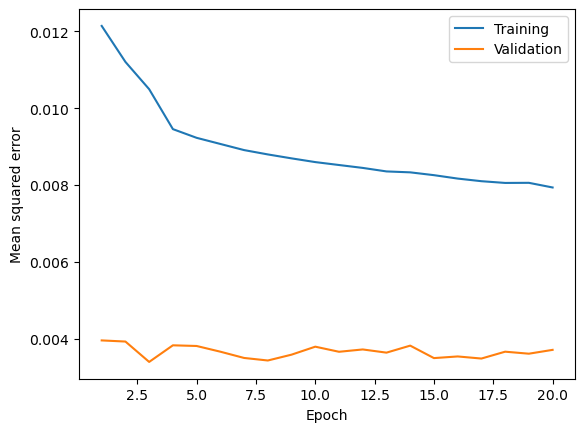

In [27]:
fig, ax = plt.subplots()

epoch = np.arange(1, len(trainer.history["Loss/train"])+1)

ax.plot(epoch, trainer.history["Loss/train"], label="Training")
ax.plot(epoch, list(map(lambda x: x.cpu(), trainer.history["Loss/valid"])), label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.legend()

plt.show()